In [1]:
import torch
from torch.utils.data import Dataset
import pandas as pd

class FakeNewsDatasetLIAR(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer
        
    def __getitem__(self, idx):
        label, statement = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)
            
        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)
            
        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)
            
        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)
            
        return (tokens_tensor, segments_tensor, label_tensor)
        
    def __len__(self):
        return self.len


In [2]:
# reforming the dataset to fit the model

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]
    
    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
    else:
        label_ids = None
        
    # zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0,1)
    
    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16

In [3]:
# model construction - replace BERT with another other pretrained model

from transformers import BertForSequenceClassification
from IPython.display import display, clear_output
from transformers import BertTokenizer

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

NUM_LABELS = 2

model = BertForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=NUM_LABELS)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
trainset = FakeNewsDatasetLIAR('train', tokenizer=tokenizer, path='./')
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

In [5]:
# fine-tuning of BERT

from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model.to(device)

model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
NUM_EPOCHS = 1

for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    train_acc = 0.0
    
    loop = tqdm(trainloader)
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=tokens_tensors,
                      token_type_ids=segments_tensors,
                      attention_mask=masks_tensors,
                      labels=labels)
        
        loss = outputs[0]
        loss.backward()
        optimizer.step()
        
        logits = outputs[1]
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())
        
        train_loss += loss.item()
        
        loop.set_description(f'Epoch [{epoch + 1}/{NUM_EPOCHS}]')
        loop.set_postfix(acc=train_acc, loss=train_loss/(batch_idx+1))

device: cpu


  0%|          | 0/175 [00:00<?, ?it/s]

In [6]:
# load all valsets

valset_liar = FakeNewsDatasetLIAR('val', tokenizer=tokenizer, path ='./')
print('liar valset size:', valset_liar.__len__())


liar valset size: 700


In [7]:
# create all valloaders

valloader_liar = DataLoader(valset_liar, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

BERT:
Confusion Matrix:

Accuracy: 0.7257142857142858
Precision: 0.7265861027190332
Recall: 0.9776422764227642
F1 Score: 0.8336221837088388


(0.7257142857142858,
 0.7265861027190332,
 0.9776422764227642,
 0.8336221837088388)

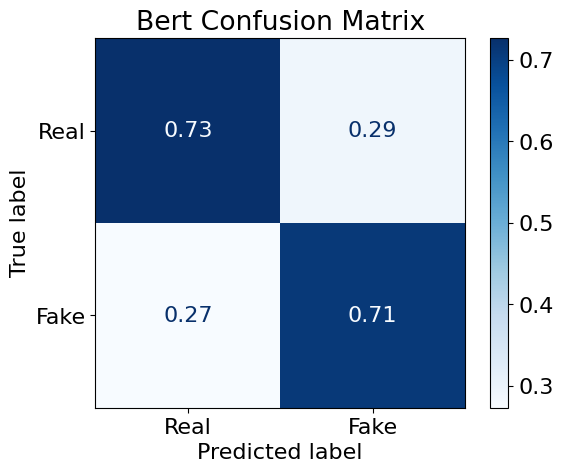

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt  # Import matplotlib

def evaluate(valloader):
    true = []
    predictions = []
    with torch.no_grad():
        model.eval()
        for data in valloader:
            if next(model.parameters()).is_cuda:
                data = [t.to(device) for t in data if t is not None]

            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            val_outputs = model(input_ids=tokens_tensors,
                               token_type_ids=segments_tensors,
                               attention_mask=masks_tensors,
                               labels=data[3])  # Include labels in the forward pass

            loss, logits = val_outputs.loss, val_outputs.logits
            _, pred = torch.max(logits, 1)

            labels = data[3]
            true.extend(labels.cpu().tolist())
            predictions.extend(pred.cpu().tolist())

    cm = confusion_matrix(true, predictions, labels=[1, 0], normalize='pred')

    # Set font size for confusion matrix plot
    plt.rcParams.update({'font.size': 16})
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
    disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=None, xticks_rotation='horizontal')

    # Add title to the confusion matrix plot
    plt.title('Bert Confusion Matrix')

    accuracy = accuracy_score(true, predictions)
    precision = precision_score(true, predictions)
    recall = recall_score(true, predictions)
    f1 = f1_score(true, predictions)
    
    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)
    
    return accuracy, precision, recall, f1

print('BERT:')
print('Confusion Matrix:')
evaluate(valloader_liar)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


device: cpu


Training Epoch [10/10]: 100%|██████████| 175/175 [09:59<00:00,  3.42s/it, acc=1, loss=0.0294]    


<Figure size 1800x800 with 0 Axes>

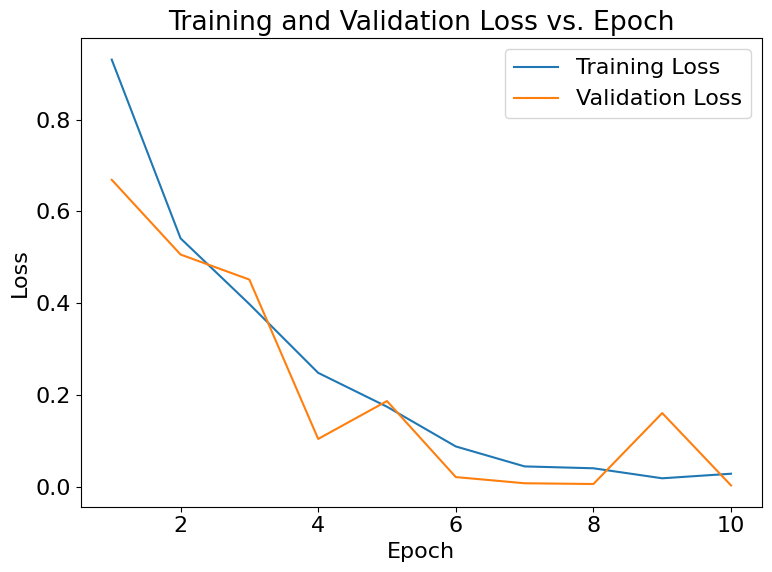

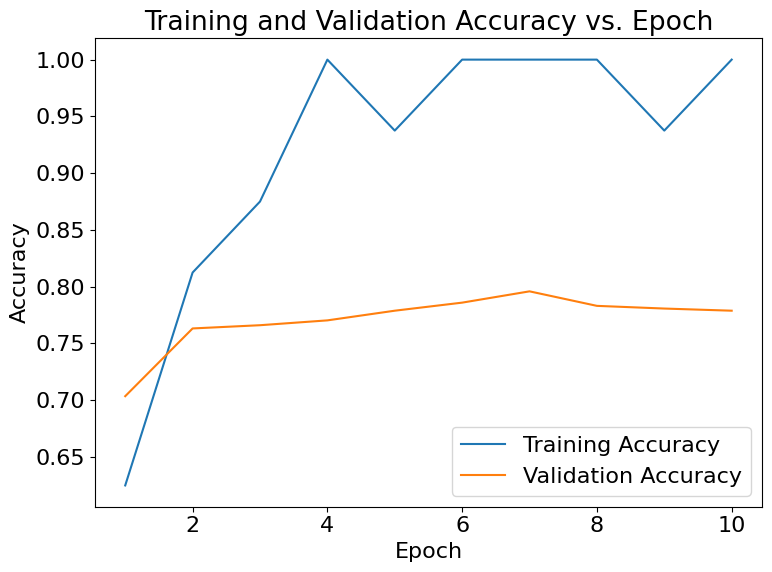

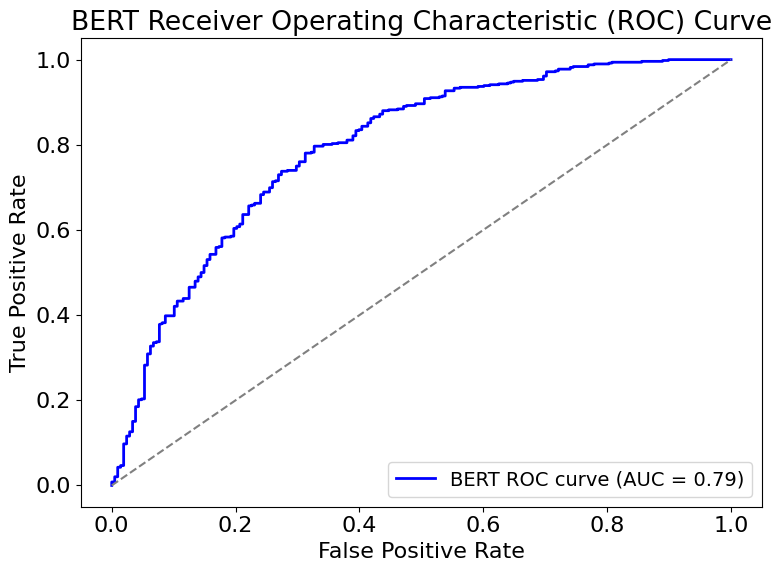

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

class FakeNewsDatasetLIAR(Dataset):
    def __init__(self, mode, tokenizer, path):
        assert mode in ['train', 'val']
        self.mode = mode
        self.df = pd.read_csv(path + mode + '.tsv', sep='\t').fillna('')
        self.len = len(self.df)
        self.tokenizer = tokenizer  # BERT tokenizer

    def __getitem__(self, idx):
        label, statement = self.df.iloc[idx, :].values
        label_tensor = torch.tensor(label)

        word_pieces = ['[CLS]']
        statement = self.tokenizer.tokenize(statement)
        word_pieces += statement + ['[SEP]']
        len_st = len(word_pieces)

        ids = self.tokenizer.convert_tokens_to_ids(word_pieces)
        tokens_tensor = torch.tensor(ids)

        segments_tensor = torch.tensor([0] * len_st, dtype=torch.long)

        return (tokens_tensor, segments_tensor, label_tensor)

    def __len__(self):
        return self.len

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    segments_tensors = [s[1] for s in samples]

    if samples[0][2] is not None:
        label_ids = torch.stack([s[2] for s in samples])
        label_ids = label_ids.squeeze()  # Squeeze to handle potential extra dimension
    else:
        label_ids = None

    # Zero padding
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = pad_sequence(segments_tensors, batch_first=True)

    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)

    return tokens_tensors, segments_tensors, masks_tensors, label_ids

BATCH_SIZE = 16
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

NUM_LABELS = 10
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
trainset = FakeNewsDatasetLIAR('train', tokenizer=tokenizer, path='./')
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

valset_bert = FakeNewsDatasetLIAR('val', tokenizer=tokenizer, path='./')
valloader_bert = DataLoader(valset_bert, batch_size=BATCH_SIZE, collate_fn=create_mini_batch)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device:', device)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
NUM_EPOCHS = 10  # Change as needed

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Training
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    loop = tqdm(trainloader)
    
    for batch_idx, data in enumerate(loop):
        tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]

        optimizer.zero_grad()

        if labels is not None:
            labels = labels.to(device, dtype=torch.long)

        outputs = model(input_ids=tokens_tensors,
                        token_type_ids=segments_tensors,
                        attention_mask=masks_tensors,
                        labels=labels)

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        logits = outputs.logits
        _, pred = torch.max(logits.data, 1)
        train_acc = accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())

        train_loss += loss.item()

        loop.set_description(f'Training Epoch [{epoch + 1}/{NUM_EPOCHS}]')
        loop.set_postfix(acc=train_acc, loss=train_loss / (batch_idx + 1))

    # Save metrics for plotting
    train_losses.append(train_loss / len(trainloader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    y_val_prob_bert = []

    with torch.no_grad():
        for data in valloader_bert:
            data = [t.to(device) for t in data if t is not None]
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            labels = data[3]

            val_outputs = model(input_ids=tokens_tensors,
                                attention_mask=masks_tensors)

            logits = val_outputs.logits
            probabilities = torch.softmax(logits, dim=1)
            y_val_prob_bert.extend(probabilities.cpu().tolist())

            _, pred = torch.max(logits, 1)

            if labels is not None:
                labels = labels.to(device, dtype=torch.long)

            val_loss += outputs.loss.item()
            val_acc += accuracy_score(pred.cpu().tolist(), labels.cpu().tolist())

    val_losses.append(val_loss / len(valloader_bert))
    val_accuracies.append(val_acc / len(valloader_bert))

# Plot training and validation loss and accuracy along with ROC curve for BERT
plt.figure(figsize=(18, 8))

plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('loss_vs_epoch.png')
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, NUM_EPOCHS + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('accuracy_vs_epoch.png')
plt.show()

# Plot ROC curve for BERT
plt.figure(figsize=(8, 6))
y_val_prob_bert = torch.tensor(y_val_prob_bert)[:, 1].numpy()
fpr_bert, tpr_bert, thresholds_bert = roc_curve(valset_bert.df['label'], y_val_prob_bert)
roc_auc_bert = auc(fpr_bert, tpr_bert)
plt.plot(fpr_bert, tpr_bert, color='blue', lw=2, label='BERT ROC curve (AUC = {:.2f})'.format(roc_auc_bert))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERT Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('roc_curve.png')
plt.show()
